We will use the same settings and hyperparameters as described [here](https://arxiv.org/pdf/2010.11929v2)

In [1]:
# Import necessary dependencies
import time
import numpy as np
import matplotlib.pyplot as plt

import einops
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

from torchsummary import summary

### Define hyperparameters and constants

In [2]:
# Model constants
PATCH_SIZE = 16
LATENT_SIZE = 768
NUM_HEADS = 12
NUM_ENCODERS = 12
IMG_SIZE = 224
N_CHANNELS = 3
DROPOUT = 0.1
NUM_CLASSES = 10 # We will use CIFAR10

# Training constants
NUM_EPOCHS = 30
BASE_LR = 0.01
WEIGHT_DECAY = 0.03
BATCH_SIZE = 4

### Load CIFAR10 dataset

In [3]:
# Define transformations
train_transforms = T.Compose(
    [
        T.RandomCrop(32, 4),
        T.Resize((IMG_SIZE)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

test_transforms = T.Compose(
    [
        T.Resize((IMG_SIZE)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [4]:
train_data = torchvision.datasets.CIFAR10(
    root='../data/cifar10/train',
    train=True,
    download=True,
    transform=train_transforms
)

test_data = torchvision.datasets.CIFAR10(
    root='../data/cifar10/test',
    train=False,
    download=True,
    transform=test_transforms
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Define class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
# Define train and test dataloaders
train_loader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=3
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=3
)

In [7]:
# Define device on which the calculations will take place
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

[source](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

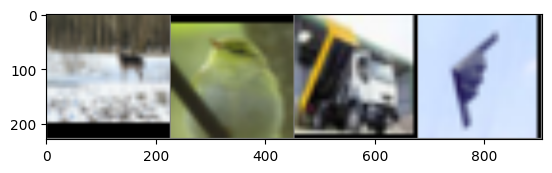

deer  bird  truck plane


In [8]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

### Generate input Embeddings

To handle 2D images, we reshape the image x ∈ R `H × W × C` into a sequence of flattened 2D patches: `N × (P^2·C)`, where (H, W) is the resolution of the original image, C is the number of channels, (P, P) is the resolution of each image patch, and `N = H·W/P^2` is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size D through all of its layers, so we
flatten the patches and map to D dimensions with a trainable linear projection. We refer to the output of this projection as the patch embeddings.


In [9]:
class PatchEmbedding(nn.Module):
    """
    Create Patch Embeddings from images.
    """
    
    def __init__(
        self,
        patch_size: int = PATCH_SIZE,
        n_channels: int = N_CHANNELS,
        n_model: int = LATENT_SIZE,
        batch_size: int = BATCH_SIZE,
        device: str = device
    ) -> None:
        super(PatchEmbedding, self).__init__()
        
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.n_model = n_model
        self.batch_size = batch_size
        self.device = device
        
        self.input_size = self.patch_size * self.patch_size * self.n_channels
        
        self.linear_projection = nn.Linear(self.input_size, self.n_model)
        
        # Class labels (random)
        self.class_label = nn.Parameter(torch.randn(self.batch_size, 1, self.n_model)).to(device)
        
        self.positional_embedding = nn.Parameter(torch.randn(self.batch_size, 1, self.n_model)).to(device)
    
    def forward(self, input):
        input = input.to(self.device)
        
        # Preprocess into patches
        patches = einops.rearrange(
            input,
            'b c (h h1) (w w1) -> b (h w) (h1 w1 c)',
            h1=self.patch_size,
            w1=self.patch_size
        )
        
        linear_projection = self.linear_projection(patches).to(self.device)
        b, n, _ = linear_projection.shape
        
        # Prepand the class label
        linear_projection = torch.cat((self.class_label, linear_projection), dim=1)
        positional_embedding = einops.repeat(
            self.positional_embedding,
            "b 1 d -> b m d",
            m=n+1
        )
        
        # Add positional embedding to the linear projection
        linear_projection = linear_projection + positional_embedding
        
        return linear_projection

In [10]:
# Test "PatchEmbedding"
test_tensor = torch.randn((4, 3, 224, 224))
test_embedder = PatchEmbedding().to(device)

print(f'Shape before: {test_tensor.shape}')
print(f'Shape after: {test_embedder(test_tensor).shape}')

Shape before: torch.Size([4, 3, 224, 224])
Shape after: torch.Size([4, 197, 768])


### VIT Encoder block implementation

Since we are solving a classification problem there is not need in the Decoder block.

In [11]:
class Encoder(nn.Module):
    def __init__(
        self,
        latent_size: int = LATENT_SIZE,
        num_heads: int = NUM_HEADS,
        dropout: float = DROPOUT,
        device: str = device
    ) -> None:
        
        super(Encoder, self).__init__()
        
        self.latent_size = latent_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.device = device
        
        # Layer Normalization
        self.layer_norm_0 = nn.LayerNorm(self.latent_size)
        self.layer_norm_1 = nn.LayerNorm(self.latent_size)
        
        # Multi-head Attention Layer
        self.multi_attn = nn.MultiheadAttention(
            embed_dim=self.latent_size,
            num_heads=self.num_heads,
            dropout=self.dropout
        )
        
        # Second part: Feed Forward layer
        self.linear = nn.Sequential(
            nn.Linear(self.latent_size, self.latent_size * 4),
            nn.GELU(),
            nn.Dropout(p=self.dropout),
            nn.Linear(self.latent_size * 4, self.latent_size),
            nn.Dropout(p=self.dropout)
        )
        
    def forward(self, input):
        
        # First part: Normalization + Attention
        input_normalized = self.layer_norm_0(input)
        attention_input_normalized, _ = self.multi_attn(input_normalized, input_normalized, input_normalized)
        
        # Residual connection #1
        residual_connection_0 = input + attention_input_normalized
        
        # Second part: Normalization + Feedforward (MLP)
        second_input_normalized = self.layer_norm_1(residual_connection_0)
        ff_out = self.linear(second_input_normalized)
        
        # Residual connection #2
        residual_connection_1 = residual_connection_0 + ff_out
        
        return residual_connection_1

In [12]:
# Test "Encoder"
test_tensor_enc = torch.randn(BATCH_SIZE, test_embedder(test_tensor).shape[1], LATENT_SIZE).to(device)
test_encoder = Encoder().to(device)

print(f'Shape before: {test_tensor_enc.shape}')
print(f'Shape after: {test_encoder(test_tensor_enc).shape}')

Shape before: torch.Size([4, 197, 768])
Shape after: torch.Size([4, 197, 768])


### Vision Transformer Implementation

In [16]:
class VIT(nn.Module):
    def __init__(
        self,
        num_layers: int = NUM_ENCODERS,
        latent_size: int = LATENT_SIZE,
        num_heads: int = NUM_HEADS,
        num_classes: int = NUM_CLASSES,
        dropout: float = DROPOUT,
        device: str = device
    ) -> None:
        
        super(VIT, self).__init__()
        
        self.num_layers = num_layers
        self.latent_size = latent_size
        self.num_heads = num_heads
        self.num_classes = num_classes
        self.dropout = dropout
        self.device = device
        
        self.patch_embedding = PatchEmbedding()
        
        # Stack Encoder layers on top of each other
        self.encoder_stack = nn.ModuleList([Encoder(self.latent_size, self.num_heads, self.dropout, self.device) for _ in range(self.num_layers)])
        
        # MLP Block for classification
        self.MLP = nn.Sequential(
            nn.LayerNorm(self.latent_size),
            nn.Linear(self.latent_size, self.latent_size),
            nn.Linear(self.latent_size, self.num_classes)
        )
        
    def forward(self, input):
        
        x = self.patch_embedding(input)
        
        for encoder_layer in self.encoder_stack:
            x = encoder_layer(x)
        
        # Extract the embedding of the class
        class_embedding = x[:, 0]
        
        result = self.MLP(class_embedding)
        
        return result

In [20]:
# Test "VIT"
test_tensor_vit = torch.randn(BATCH_SIZE, 3, 224, 224).to(device)
test_vit = VIT()

print(f'Shape before: {test_tensor_vit.shape}')
print(f'Shape after: {test_vit(test_tensor_vit).shape}')

Shape before: torch.Size([4, 3, 224, 224])
Shape after: torch.Size([4, 10])


In order to transform output tensor values into probabilities [0, 1], we use Softmax function.